---
title: "Joint Petrophysically-Guided Inversion"
authors:
  - id: thibautastic
---

```{admonition} Advanced notebook
:class: danger
This tutorial focusses on advanced functionality within SimPEG. Basic and intermediate level functionality are not discussed in detail, as we assume the user is already an experienced SimPEG user.
```

```{admonition} Medium-weight notebook
:class: caution
Requires moderate computational resources. Run-times may exceed several minutes and require up to 8 GB of available RAM.
```

**Keywords:** joint inversion, petrophysically-guided inversion, Gaussian mixture model.

</br>

**Summary:** Here, we consider two geophysical datasets whose diagnostic physical properties are different (e.g. gravity and magnetic data). If collected over the same region, we expect independent inversion of these datasets to recover models containing similar structures. Here, we demonstrate joint inversion using the [CrossGradient](xref:simpeg#simpeg.regularization.CrossGradient) regularization class. Cross-gradient enforces similar structures in the recovered models for different physical properties. For this tutorial, we jointly invert gravity and magnetic data to recover density contrast and magnetic susceptibility models. However, this approach can be applied to any other combination of geophysical datasets.

</br>

**Learning Objectives:**

- Considering mesh design for multiple datasets.
- How to define the data misfit and regularization for multiple datasets and physical property types.
- How to implement inversion directives for joint inversion.

This tutorial shows through a joint inversion of Gravity and Magnetic data on an
Octree mesh how to use the PGI framework introduced in Astic & Oldenburg (2019)
and Astic et al. (2021) to include petrophysical information into geophysical
inversions for mutli-physics inversion.

Thibaut Astic, Douglas W. Oldenburg,
A framework for petrophysically and geologically guided geophysical inversion
using a dynamic Gaussian mixture model prior, Geophysical Journal International,
Volume 219, Issue 3, December 2019, Pages 1989–2012, DOI:
`10.1093/gji/ggz389 <https://doi.org/10.1093/gji/ggz389>`_.


Thibaut Astic, Lindsey J. Heagy, Douglas W Oldenburg,
Petrophysically and geologically guided multi-physics inversion using a dynamic
Gaussian mixture model, Geophysical Journal International,
Volume 224, Issue 1, January 2021, Pages 40-68, DOI: `10.1093/gji/ggaa378
<https://doi.org/10.1093/gji/ggaa378>`_.


## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise.

In [1]:
# simpeg functionality
import simpeg.potential_fields as pf
from simpeg import (
    data_misfit,
    directives,
    inverse_problem,
    inversion,
    maps,
    optimization,
    regularization,
    utils,
)
from simpeg.utils import io_utils, plot2Ddata

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# General Python functionality
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

## Load Tutorial Files

Here, we download and import the files required to run the tutorial. These files are stored within a Google Cloud bucket. To shorten the length of the tutorial, we will:

* load gravity data from a UBC-GIF formatted data file $\rightarrow$ SimPEG [Data](xref:simpeg#simpeg.data.Data) object
* load magnetic data from a UBC-GIF formatted data file $\rightarrow$ SimPEG [Data](xref:simpeg#simpeg.data.Data) object
* load topography from an xyz file $\rightarrow$ (n, 3) [numpy.ndarray](xref:numpy#numpy.ndarray)
* load an OcTree mesh from a UBC-GIF formatted file $\rightarrow$ discretize [TreeMesh](xref:discretize#discretize.TreeMesh) object

In [2]:
# Load gravity data
data_grav_file = io_utils.download(
    "https://storage.googleapis.com/simpeg/pgi_tutorial_assets/gravity_data.obs",
)
data_grav = io_utils.read_grav3d_ubc(data_grav_file)

file already exists, new file is called D:\Documents\Repositories\user-tutorials\notebooks\11-joint-inversion\gravity_data.obs
   saved to: D:\Documents\Repositories\user-tutorials\notebooks\11-joint-inversion\gravity_data.obs
Download completed!


In [3]:
# Load magnetic data
data_mag_file = io_utils.download(
    "https://storage.googleapis.com/simpeg/pgi_tutorial_assets/magnetic_data.obs"
)
data_mag = io_utils.read_mag3d_ubc(data_mag_file)

file already exists, new file is called D:\Documents\Repositories\user-tutorials\notebooks\11-joint-inversion\magnetic_data.obs
   saved to: D:\Documents\Repositories\user-tutorials\notebooks\11-joint-inversion\magnetic_data.obs
Download completed!


In [35]:
# Load the mesh
mesh_file = io_utils.download(
    "https://storage.googleapis.com/simpeg/pgi_tutorial_assets/mesh_tutorial.ubc"
)
mesh = TreeMesh.read_UBC(mesh_file)

file already exists, new file is called D:\Documents\Repositories\user-tutorials\notebooks\11-joint-inversion\mesh_tutorial.ubc
   saved to: D:\Documents\Repositories\user-tutorials\notebooks\11-joint-inversion\mesh_tutorial.ubc
Download completed!


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\discretize\mixins\mesh_io.py:495: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  mesh = TreeMesh(hs, origin=origin)


In [5]:
# Load topography
topo_file = io_utils.download(
    "https://storage.googleapis.com/simpeg/pgi_tutorial_assets/CDED_Lake_warp.xyz"
)
xyz_topo = np.genfromtxt(topo_file, skip_header=1)

file already exists, new file is called D:\Documents\Repositories\user-tutorials\notebooks\11-joint-inversion\CDED_Lake_warp.xyz
   saved to: D:\Documents\Repositories\user-tutorials\notebooks\11-joint-inversion\CDED_Lake_warp.xyz
Download completed!


In [6]:
# Load True geological model for comparison with inversion result
true_geology_file = io_utils.download(
    "https://storage.googleapis.com/simpeg/pgi_tutorial_assets/geology_true.mod"
)
true_geology = mesh.read_model_UBC(true_geology_file)

file already exists, new file is called D:\Documents\Repositories\user-tutorials\notebooks\11-joint-inversion\geology_true.mod
   saved to: D:\Documents\Repositories\user-tutorials\notebooks\11-joint-inversion\geology_true.mod
Download completed!


## Plot the Observed Data and Topography

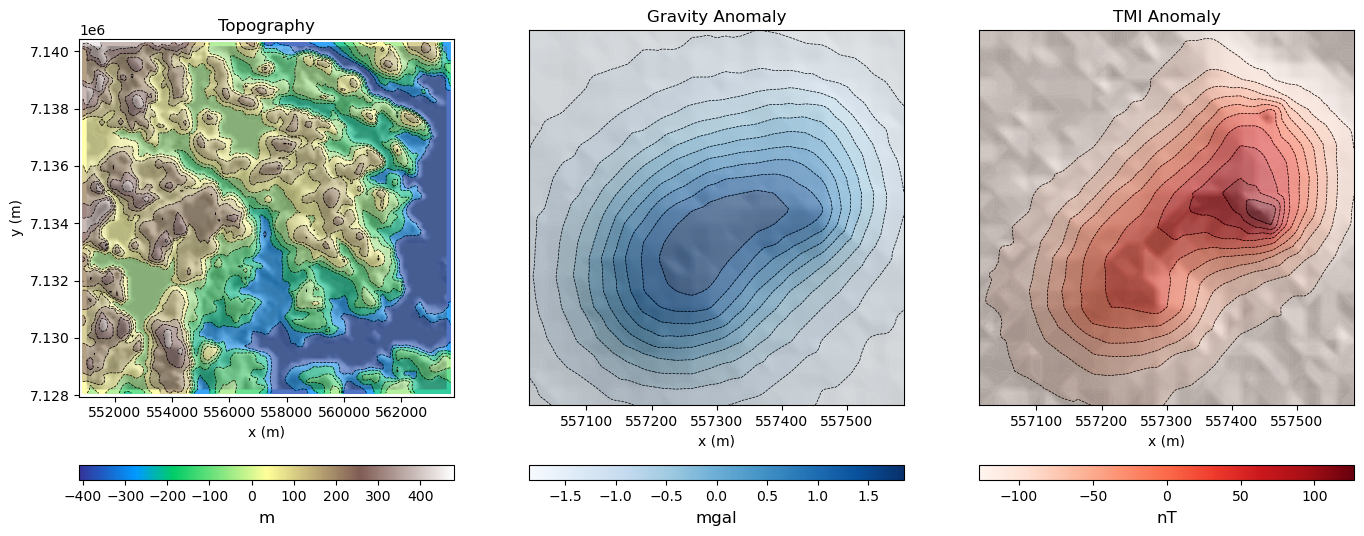

In [7]:
fig = plt.figure(figsize=(15, 5))

loc_list = [
    xyz_topo,
    data_grav.survey.receiver_locations,
    data_mag.survey.receiver_locations
]
data_list = [xyz_topo[:, -1], data_grav.dobs, data_mag.dobs]
title_list = ["Topography", "Gravity Anomaly", "TMI Anomaly"]
cmap_list = [mpl.cm.terrain, mpl.cm.Blues, mpl.cm.Reds]
label_list = ["m", "mgal", "nT"]

ax = [fig.add_axes([0.1+0.3*ii, 0.2, 0.25, 0.75]) for ii in range(3)]
cax = [fig.add_axes([0.1+0.3*ii, 0.05, 0.25, 0.03]) for ii in range(3)]
norm = 3 * [None]
cbar = 3 * [None]

for ii in range(3):

    d = data_list[ii]
    plot2Ddata(
        loc_list[ii],
        d, ax=ax[ii],
        level=True,
        nx=100,
        ny=100,
        # dataloc=True,
        ncontour=11,
        shade=True,
        contourOpts={"cmap": cmap_list[ii], "alpha": 0.8},
        levelOpts={"colors": "k", "linewidths": 0.5, "linestyles": "dashed"},
    )

    ax[ii].set_xlabel("x (m)")
    if ii == 0:
        ax[ii].set_ylabel("y (m)")
        norm[ii] = mpl.colors.Normalize(vmin=-np.min(d), vmax=np.max(d))
    else:
        ax[ii].set_yticks([])
        norm[ii] = mpl.colors.Normalize(
            vmin=-np.max(np.abs(d)), vmax=np.max(np.abs(d))
        )
    ax[ii].set_title(title_list[ii])
    
    cbar[ii] = mpl.colorbar.ColorbarBase(
        cax[ii], norm=norm[ii], orientation="horizontal", cmap=cmap_list[ii]
    )
    cbar[ii].set_label(label_list[ii], rotation=0, labelpad=5, size=12)

## Problem Setup

H

### Defining the Model and Mappings

In [8]:
# Find the indicies of the active cells (ones below surface)
active_cells = active_from_xyz(mesh, xyz_topo, 'CC')

# Number of model parameters for each physical property type
nP = int(active_cells.sum())

In [9]:
# Create Wires Map that maps from stacked models to individual model components
# m1 refers to density model, m2 refers to susceptibility
wires_map = maps.Wires(("density", nP), ("susceptibility", nP))

In [10]:
# Define mapping from model to active cells (potential fields) or all cells
# (electromagnetics)
density_map = wires_map.density

susceptibility_map = wires_map.susceptibility

### Starting/Reference Model

In [11]:
# Define density contrast values for each unit
starting_density, starting_susceptibility = 1e-6, 1e-6

# Define the starting model
starting_model = np.r_[
    starting_density * np.ones(nP), starting_susceptibility * np.ones(nP)
]

### Simulations

In [12]:
simulation_grav = pf.gravity.simulation.Simulation3DIntegral(
    survey=data_grav.survey,
    mesh=mesh,
    rhoMap=density_map,
    active_cells=active_cells,
    engine="choclo",
)

In [13]:
simulation_mag = pf.magnetics.simulation.Simulation3DIntegral(
    survey=data_mag.survey,
    mesh=mesh,
    chiMap=susceptibility_map,
    active_cells=active_cells,
    engine="choclo",
)

## Inversion With Full Petrophysical Information

### Define Known Petrophysical Gaussian Mixture Model

The GMM is our representation of the petrophysical and geological information.
Here, we focus on the petrophysical aspect, with the means and covariances of
the physical properties of each rock unit.
To generate the data above, the PK unit was populated with a density contrast
of -0.8 g/cc and a magnetic susceptibility of 0.005 SI. The properties of the
HK unit were set at -0.2 g/cc and 0.02 SI. The covariances matrices are set
so that we assume petrophysical noise levels of around 0.05 g/cc and 0.001 SI
for both unit. Finally the background unit is set at null contrasts (0 g/cc
0 SI) with a petrophysical noise level of half of the above.

In [15]:
gmmref = utils.WeightedGaussianMixture(
    n_components=3,  # number of rock units: bckgrd, PK, HK
    mesh=mesh,
    actv=active_cells,
    covariance_type="diag",  # diagonal covariances
)

In [16]:
# required: initialization with fit
# fake random samples, size of the mesh, number of physical properties: 2 (density and mag.susc)
rng = np.random.default_rng(seed=518936)
gmmref.fit(rng.normal(size=(nP, 2)))

C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


WeightedGaussianMixture(actv=array([ True,  True,  True, ..., False, False, False]),
                        covariance_type='diag',
                        mesh=
OcTreeMesh: 42.77% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  3   :       162            ---------------------------   --------------------
  4   :      1221         x:   556900.0   ,  557700.0         25.0   ,   100.0   
  5   :      12632        y:   7133200.0  ,  7134000.0        25.0   ,   100.0   
-----------------------   z:    -307.5    ,    492.5          25.0   ,   100.0   
Total :      14015     ,
                        n_components=3)

In [17]:
# set parameters manually
# set phys. prop means for each unit
gmmref.means_ = np.c_[
    [0.0, 0.0],  # BCKGRD density contrast and mag. susc
    [-0.8, 0.005],  # PK
    [-0.2, 0.02],  # HK
].T
# set phys. prop covariances for each unit
gmmref.covariances_ = np.array(
    [[6e-04, 3.175e-07], [2.4e-03, 1.5e-06], [2.4e-03, 1.5e-06]]
)

In [18]:
# important after setting cov. manually: compute precision matrices and cholesky
gmmref.compute_clusters_precisions()
# set global proportions; low-impact as long as not 0 or 1 (total=1)
gmmref.weights_ = np.r_[0.9, 0.075, 0.025]

C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


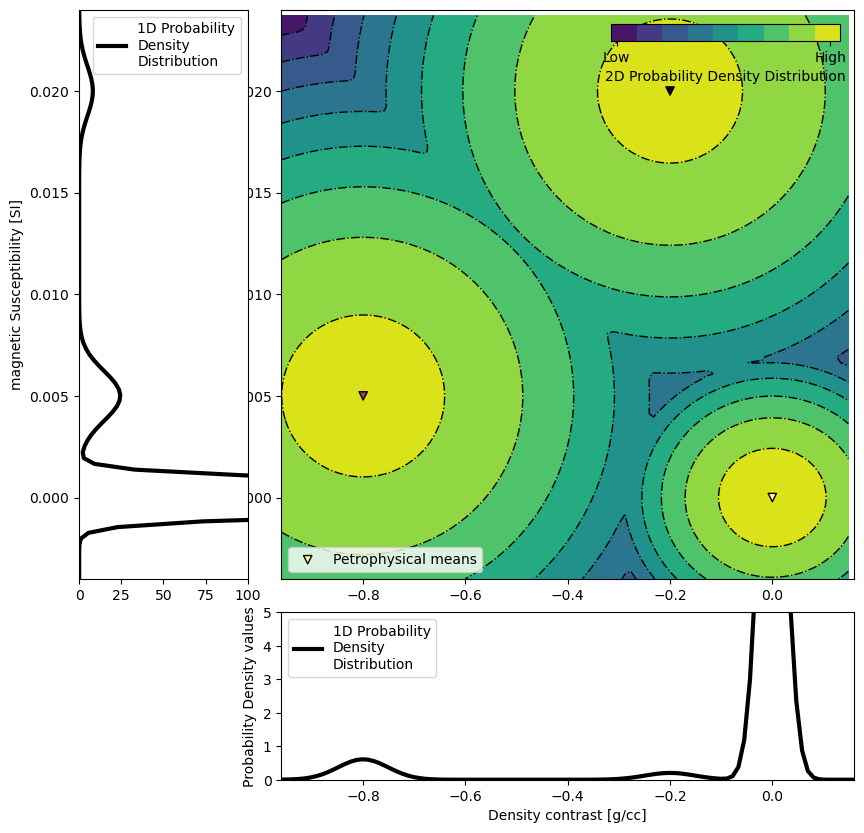

In [19]:
# Plot the 2D GMM
ax = gmmref.plot_pdf(flag2d=True)
ax[0].set_xlabel("Density contrast [g/cc]")
ax[0].set_ylim([0, 5])
ax[2].set_ylabel("magnetic Susceptibility [SI]")
ax[2].set_xlim([0, 100])
plt.show()

### Data Misfit

In [20]:
# Define a data misfit for each dataset
dmis_grav = data_misfit.L2DataMisfit(data=data_grav, simulation=simulation_grav)
dmis_mag = data_misfit.L2DataMisfit(data=data_mag, simulation=simulation_mag)

# Add to make a combo objective function
dmis = 0.5 * dmis_grav + 0.5 * dmis_mag

# Multipliers for the combo objective function
print(dmis.multipliers)

[0.5, 0.5]


### Regularization

In [21]:
# Sensitivity weighting
wr_grav = np.sum(simulation_grav.G**2.0, axis=0) ** 0.5 / (mesh.cell_volumes[active_cells])
wr_grav = wr_grav / np.max(wr_grav)

wr_mag = np.sum(simulation_mag.G**2.0, axis=0) ** 0.5 / (mesh.cell_volumes[active_cells])
wr_mag = wr_mag / np.max(wr_mag)

In [22]:
reg_map = maps.IdentityMap(nP=nP)

# create joint PGI regularization with smoothness
reg = regularization.PGI(
    gmmref=gmmref,
    mesh=mesh,
    wiresmap=wires_map,
    maplist=[reg_map, reg_map],
    active_cells=active_cells,
    alpha_pgi=1.0,
    alpha_x=1.0,
    alpha_y=1.0,
    alpha_z=1.0,
    alpha_xx=0.0,
    alpha_yy=0.0,
    alpha_zz=0.0,
    # use the classification of the initial model (here, all background unit)
    # as initial reference model
    reference_model=utils.mkvc(
        gmmref.means_[gmmref.predict(starting_model.reshape(nP, -1))]
    ),
    weights_list=[wr_grav, wr_mag],  # weights each phys. prop. by correct sensW
)

C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


### Optimization

In [23]:
lowerbound = np.r_[-2.0 * np.ones(nP), 0.0 * np.ones(nP)]
upperbound = np.r_[0.0 * np.ones(nP), 1e-1 * np.ones(nP)]
opt = optimization.ProjectedGNCG(
    maxIter=30,
    lower=lowerbound,
    upper=upperbound,
    maxIterLS=20,
    maxIterCG=100,
    tolCG=1e-4,
)

### Inverse Problem

In [24]:
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

### Define PGI Directives

In [25]:
# Directives
# Add directives to the inversion
# ratio to use for each phys prop. smoothness in each direction;
# roughly the ratio of the order of magnitude of each phys. prop.
alpha0_ratio = np.r_[
    1e-4 * np.ones(len(reg.objfcts[1].objfcts[1:])),
    1e-4 * 100.0 * np.ones(len(reg.objfcts[2].objfcts[1:])),
]
Alphas = directives.AlphasSmoothEstimate_ByEig(alpha0_ratio=alpha0_ratio, verbose=True)
# initialize beta and beta/alpha_pgi schedule
beta = directives.BetaEstimate_ByEig(beta0_ratio=1e-2)
betaIt = directives.PGI_BetaAlphaSchedule(
    verbose=True,
    coolingFactor=2.0,
    tolerance=0.2,
    progress=0.2,
)
# geophy. and petro. target misfits
targets = directives.MultiTargetMisfits(
    verbose=True,
)
# add learned mref in smooth once stable
MrefInSmooth = directives.PGI_AddMrefInSmooth(
    wait_till_stable=True,
    verbose=True,
)
# update the parameters in smallness (L2-approx of PGI)
update_smallness = directives.PGI_UpdateParameters(
    update_gmm=False  # keep GMM model fixed
)
# pre-conditioner
update_Jacobi = directives.UpdatePreconditioner()
# iteratively balance the scaling of the data misfits
scaling_init = directives.ScalingMultipleDataMisfits_ByEig(chi0_ratio=[1.0, 100.0])
scale_schedule = directives.JointScalingSchedule(verbose=True)

directives_list=[
    Alphas,
    scaling_init,
    beta,
    update_smallness,
    targets,
    scale_schedule,
    betaIt,
    MrefInSmooth,
    update_Jacobi,
],

### Define and Run the Inversion

In [26]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(
    inv_prob,
    # directives: evaluate alphas (and data misfits scales) before beta
    directiveList=[
        Alphas,
        scaling_init,
        beta,
        update_smallness,
        targets,
        scale_schedule,
        betaIt,
        MrefInSmooth,
        update_Jacobi,
    ],
)

# Run inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
Alpha scales: [np.float64(82829.77872017295), np.float64(0.0), np.float64(58737.27706962629), np.float64(0.0), np.float64(126261.20000574926), np.float64(0.0), np.float64(9680221.31636668), np.float64(0.0), np.float64(6858416.741694813), np.float64(0.0), np.float64(19719731.16705065), np.float64(0.0)]
<class 'simpeg.regularization.pgi.PGIsmallness'>
Initial data misfit scales:  [0.98063016 0.01936984]
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.18e-06  4.28e+06  9.96e+00  4.28e+06    2.17e+02      0              
geophys.

C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 245033.9 (target 576.0 [False]); 13933.6 (target 576.0 [False]) | smallness misfit: 297937.6 (target: 23438.0 [False])
Beta cooling evaluation: progress: [245033.9  13933.6]; minimum progress targets: [3477376.4   37090.9]
mref changed in  929  places
   2  4.18e-06  2.41e+05  3.07e+08  2.42e+05    1.44e+01      0   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 7048.1 (target 576.0 [False]); 1261.7 (target 576.0 [False]) | smallness misfit: 48871.6 (target: 23438.0 [False])
Beta cooling evaluation: progress: [7048.1 1261.7]; minimum progress targets: [196027.1  11146.9]
mref changed in  29  places
   3  4.18e-06  6.94e+03  1.43e+08  7.53e+03    2.07e+01      0              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 3933.8 (target 576.0 [False]); 431.5 (target 576.0 [True]) | smallness misfit: 39642.5 (target: 23438.0 [False])
Updating scaling for data misfits by  1.3349736253635691
New scales: [0.98541961 0.01458039]
Beta cooling evaluation: progress: [3933.8  431.5]; minimum progress targets: [5638.5 1009.4]
mref changed in  1  places
   4  4.18e-06  3.88e+03  1.32e+08  4.43e+03    2.09e+01      0   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 599.2 (target 576.0 [False]); 340.8 (target 576.0 [True]) | smallness misfit: 38698.4 (target: 23438.0 [False])
Updating scaling for data misfits by  1.6903219265194518
New scales: [0.99132252 0.00867748]
Beta cooling evaluation: progress: [599.2 340.8]; minimum progress targets: [3147.1  691.2]
mref changed in  0  places
   5  4.18e-06  5.97e+02  1.33e+08  1.15e+03    2.10e+01      0   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 401.5 (target 576.0 [True]); 212.6 (target 576.0 [True]) | smallness misfit: 37871.1 (target: 23438.0 [False])
Beta cooling evaluation: progress: [401.5 212.6]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  2.0720348653863123
mref changed in  0  places
Add mref to Smoothness. Changes in mref happened in 0.0 % of the cells
   6  4.18e-06  4.00e+02  2.21e+08  1.32e+03    3.87e+01      0   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 471.3 (target 576.0 [True]); 394.9 (target 576.0 [True]) | smallness misfit: 28343.3 (target: 23438.0 [False])
Beta cooling evaluation: progress: [471.3 394.9]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  2.7772804888477842
mref changed in  0  places
Add mref to Smoothness. Changes in mref happened in 0.0 % of the cells
   7  4.18e-06  4.71e+02  2.35e+08  1.45e+03    4.08e+01      0              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 441.6 (target 576.0 [True]); 2520.6 (target 576.0 [False]) | smallness misfit: 22928.9 (target: 23438.0 [True])
Updating scaling for data misfits by  1.304485983515494
New scales: [0.98871018 0.01128982]
Beta cooling evaluation: progress: [ 441.6 2520.6]; minimum progress targets: [691.2 691.2]
Decreasing beta to counter data misfit increase.
mref changed in  0  places
   8  2.09e-06  4.65e+02  2.19e+08  9.23e+02    2.84e+01      0              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 356.3 (target 576.0 [True]); 341.3 (target 576.0 [True]) | smallness misfit: 24219.5 (target: 23438.0 [False])
Beta cooling evaluation: progress: [356.3 341.3]; minimum progress targets: [ 691.2 2016.5]
Warming alpha_pgi to favor clustering:  4.587979019117869
mref changed in  0  places
Add mref to Smoothness. Changes in mref happened in 0.0 % of the cells
   9  2.09e-06  3.56e+02  3.56e+08  1.10e+03    2.44e+01      0              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 404.7 (target 576.0 [True]); 613.7 (target 576.0 [False]) | smallness misfit: 20819.9 (target: 23438.0 [True])
Updating scaling for data misfits by  1.4233077630153064
New scales: [0.98400754 0.01599246]
Beta cooling evaluation: progress: [404.7 613.7]; minimum progress targets: [691.2 691.2]
mref changed in  0  places
  10  2.09e-06  4.08e+02  3.21e+08  1.08e+03    3.36e+01      0              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 402.7 (target 576.0 [True]); 325.1 (target 576.0 [True]) | smallness misfit: 20713.8 (target: 23438.0 [True])
All targets have been reached
Beta cooling evaluation: progress: [402.7 325.1]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  7.345563542341645
mref changed in  0  places
Add mref to Smoothness. Changes in mref happened in 0.0 % of the cells
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 4.2785e+05
0 : |xc-x_last| = 1.4436e-01 <= tolX*(1+|x0|) = 1.0001e-01
0 : |proj(x-g)-x|    = 3.3556e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.3556e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      30    <= iter          =     11
------------------------- DONE! -------------------------


### Recovered Models

In [28]:
# Extract the results
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)
density_model = plotting_map * wires_map.density * recovered_model
susceptibility_model = plotting_map * wires_map.susceptibility * recovered_model
quasi_geo_model = plotting_map * reg.objfcts[0].compute_quasi_geology_model()

In [71]:
def plot_models(quasi_geo_model, density_model, susceptibility_model):

    fig = plt.figure(figsize=(15, 6))

    title_list = ["True Geology", "Density Model", "Susceptibility Model"]
    cmap_list = [mpl.cm.inferno_r, mpl.cm.Blues_r, mpl.cm.Reds]
    label_list = ["m", "mgal", "nT"]

    ax = [fig.add_axes([0.1+0.3*ii, 0.2, 0.25, 0.75]) for ii in range(3)]
    cax = [fig.add_axes([0.1+0.3*ii, 0.05, 0.25, 0.03]) for ii in range(3)]
    clim = [[0, 2], [-1, 0], [0, 0.025]]
    norm = 3 * [None]
    cbar = 3 * [None]

    for ii, m in enumerate([quasi_geo_model, density_model, susceptibility_model]):

        norm[ii] = mpl.colors.Normalize(vmin=clim[ii][0], vmax=clim[ii][1])

        mesh.plot_slice(
            m.copy(),
            normal="Y",
            norm=norm[ii],
            ax=ax[ii],
            ind=18,
            pcolor_opts={"cmap": cmap_list[ii]}
        )
        ax[ii].set_xlabel("x (m)")
        if ii > 0:
            ax[ii].set_ylabel("")
            ax[ii].set_yticks([])
 
        ax[ii].set_title(title_list[ii])
        
        cbar[ii] = mpl.colorbar.ColorbarBase(
            cax[ii], norm=norm[ii], orientation="horizontal", cmap=cmap_list[ii]
        )
        cbar[ii].set_label(label_list[ii], rotation=0, labelpad=5, size=12)

    fig.show()

C:\Users\devin\AppData\Local\Temp\ipykernel_24020\3091177049.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


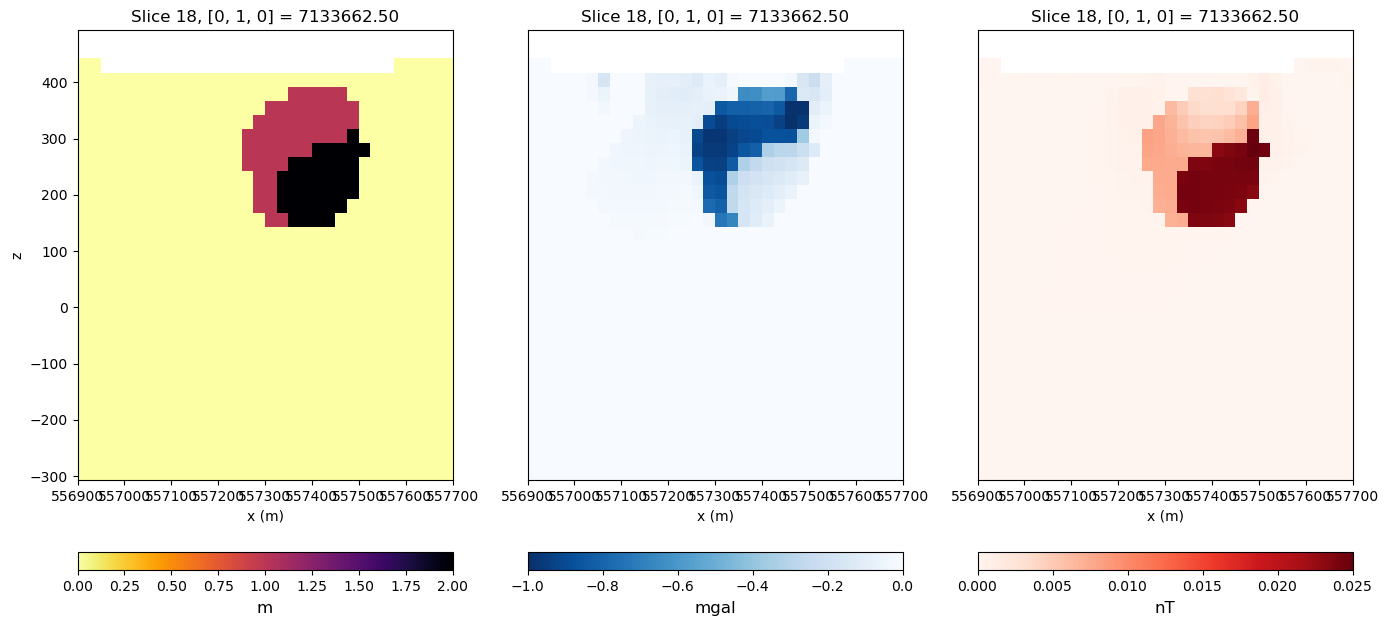

In [70]:
plot_models(quasi_geo_model, density_model, susceptibility_model)

### Plot the Gaussian Mixture Model

C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


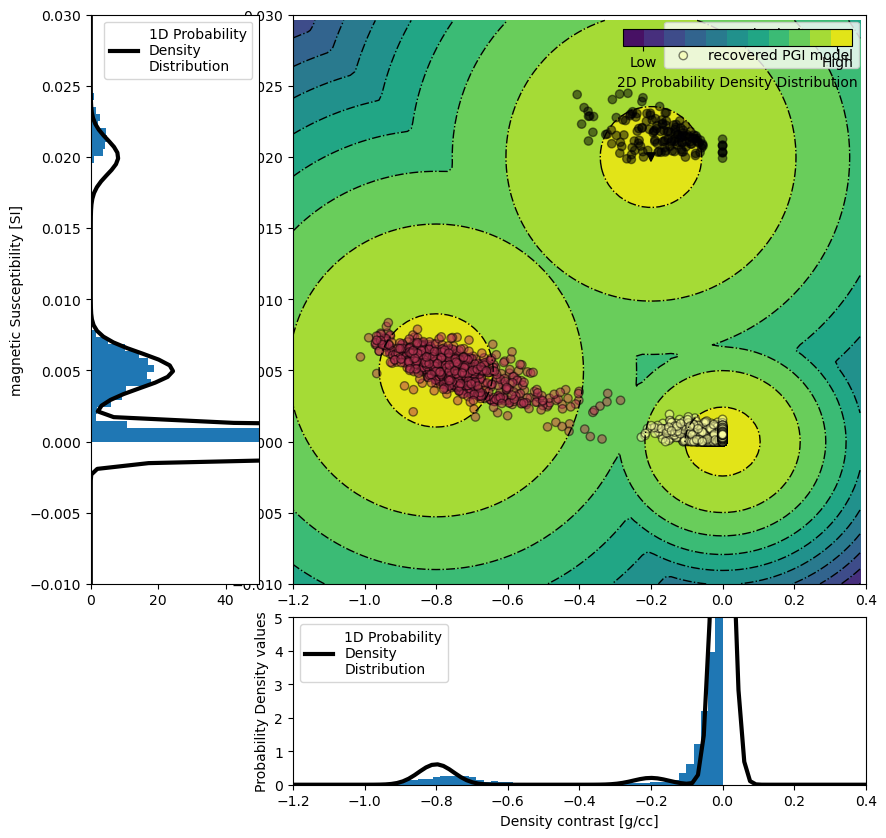

In [72]:
# Plot the 2D GMM
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((4, 4), (3, 1), colspan=3)
ax1 = plt.subplot2grid((4, 4), (0, 1), colspan=3, rowspan=3)
ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=3)
ax = [ax0, ax1, ax2]
reg.objfcts[0].gmm.plot_pdf(flag2d=True, ax=ax, padding=0.5)
ax[0].set_xlabel("Density contrast [g/cc]")
ax[0].set_ylim([0, 5])
ax[2].set_xlim([0, 50])
ax[2].set_ylabel("magnetic Susceptibility [SI]")
ax[1].scatter(
    density_model[active_cells],
    susceptibility_model[active_cells],
    c=quasi_geo_model[active_cells],
    cmap="inferno_r",
    edgecolors="k",
    label="recovered PGI model",
    alpha=0.5,
)
ax[1].legend()
ax[0].hist(density_model[active_cells], density=True, bins=50)
ax[2].hist(susceptibility_model[active_cells], density=True, bins=50, orientation="horizontal")
plt.show()

## Inversion with no petrophysical information about the means

In this scenario, we do not know the true petrophysical signature of each rock
unit. We thus make geologic assumptions to design a coupling term and perform
a multi-physics inversion. in addition to a neutral background, we assume that
one rock unit is only less dense, and the third one is only magnetic. As we
do not know their mean petrophysical values. We start with an initial guess
(-1 g/cc) for the updatable mean density-contrast value of the less dense unit
(with a fixed susceptibility of 0 SI). The magnetic-contrasting unit's updatable
susceptibility is initialized at a value of 0.1 SI (with a fixed 0 g/cc density
contrast). We then let the algorithm learn a suitable set of means under the set
constrained (fixed or updatable value), through the kappa argument, denoting our
confidences in each initial mean value (high confidence: fixed value; low
confidence: updatable value).

### Create a petrophysical GMM initial guess

The GMM is our representation of the petrophysical and geological information.
Here, we focus on the petrophysical aspect, with the means and covariances of
the physical properties of each rock unit.
To generate the data above, the PK unit was populated with a density contrast
of -0.8 g/cc and a magnetic susceptibility of 0.005 SI. The properties of the
HK unit were set at -0.2 g/cc and 0.02 SI. But here, we assume we
do not have this information. Thus, we start with initial guess for the means
and confidences kappa such that one unit is only less dense and one unit is only
magnetic, both embedded in a neutral background. The covariances matrices are set
so that we assume petrophysical noise levels of around 0.05 g/cc and 0.001 SI
for both unit. The background unit is set at a fixed null contrasts (0 g/cc
0 SI) with a petrophysical noise level of half of the above.

In [73]:
gmmref_2 = utils.WeightedGaussianMixture(
    n_components=3,  # number of rock units: bckgrd, PK, HK
    mesh=mesh,  # inversion mesh
    actv=active_cells,  # active_cells cells
    covariance_type="diag",  # diagonal covariances
)

In [74]:
# required: initialization with fit
# fake random samples, size of the mesh
# number of physical properties: 2 (density and mag.susc)
rng = np.random.default_rng(seed=518936)
gmmref_2.fit(rng.normal(size=(nP, 2)))

WeightedGaussianMixture(actv=array([ True,  True,  True, ..., False, False, False]),
                        covariance_type='diag',
                        mesh=
OcTreeMesh: 42.77% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  3   :       162            ---------------------------   --------------------
  4   :      1221         x:   556900.0   ,  557700.0         25.0   ,   100.0   
  5   :      12632        y:   7133200.0  ,  7134000.0        25.0   ,   100.0   
-----------------------   z:    -307.5    ,    492.5          25.0   ,   100.0   
Total :      14015     ,
                        n_components=3)

In [75]:
# set parameters manually
# set phys. prop means for each unit
gmmref_2.means_ = np.c_[
    [0.0, 0.0],  # BCKGRD density contrast and mag. susc
    [-1, 0.0],  # PK
    [0, 0.1],  # HK
].T
# set phys. prop covariances for each unit
gmmref_2.covariances_ = np.array(
    [[6e-04, 3.175e-07], [2.4e-03, 1.5e-06], [2.4e-03, 1.5e-06]]
)

In [76]:
# important after setting cov. manually: compute precision matrices and cholesky
gmmref_2.compute_clusters_precisions()
# set global proportions; low-impact as long as not 0 or 1 (total=1)
gmmref_2.weights_ = np.r_[0.9, 0.075, 0.025]

C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


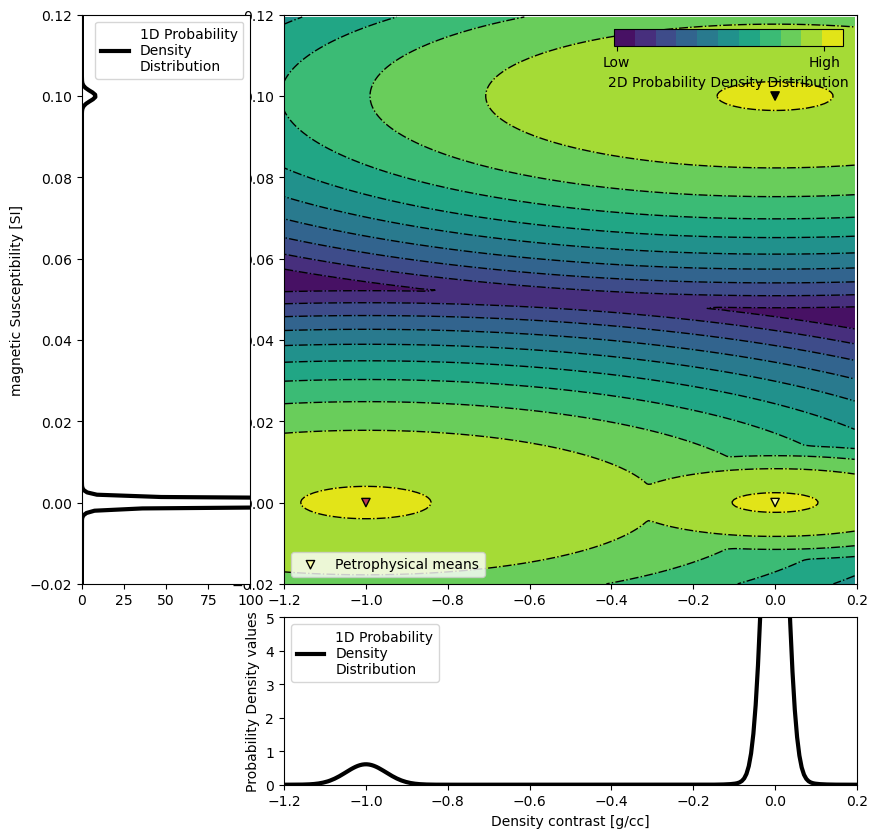

In [77]:
# Plot the 2D GMM
ax = gmmref_2.plot_pdf(flag2d=True, plotting_precision=250)
ax[0].set_xlabel("Density contrast [g/cc]")
ax[0].set_ylim([0, 5])
ax[2].set_ylabel("magnetic Susceptibility [SI]")
ax[2].set_xlim([0, 100])
plt.show()

In [78]:
# create joint PGI regularization with smoothness
reg_2 = regularization.PGI(
    gmmref=gmmref_2,
    mesh=mesh,
    wiresmap=wires_map,
    maplist=[reg_map, reg_map],
    active_cells=active_cells,
    alpha_pgi=1.0,
    alpha_x=1.0,
    alpha_y=1.0,
    alpha_z=1.0,
    alpha_xx=0.0,
    alpha_yy=0.0,
    alpha_zz=0.0,
    # use the classification of the initial model (here, all background unit)
    # as initial reference model
    reference_model=utils.mkvc(
        gmmref.means_[gmmref.predict(starting_model.reshape(nP, -1))]
    ),
    weights_list=[wr_grav, wr_mag],  # weights each phys. prop. by correct sensW
)

C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


In [79]:
# create inverse problem
inv_prob_2 = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [80]:
# Directives
# Add directives to the inversion
# ratio to use for each phys prop. smoothness in each direction:
# roughly the ratio of range of each phys. prop.
alpha0_ratio = np.r_[
    1e-2 * np.ones(len(reg.objfcts[1].objfcts[1:])),
    1e-2 * 100.0 * np.ones(len(reg.objfcts[2].objfcts[1:])),
]
Alphas = directives.AlphasSmoothEstimate_ByEig(alpha0_ratio=alpha0_ratio, verbose=True)
# initialize beta and beta/alpha_s schedule
beta = directives.BetaEstimate_ByEig(beta0_ratio=1e-4)
betaIt = directives.PGI_BetaAlphaSchedule(
    verbose=True,
    coolingFactor=2.0,
    tolerance=0.2,
    progress=0.2,
)
# geophy. and petro. target misfits
targets = directives.MultiTargetMisfits(
    verbose=True,
    chiSmall=0.5,  # ask for twice as much clustering (target value is /2)
)
# add learned mref in smooth once stable
MrefInSmooth = directives.PGI_AddMrefInSmooth(
    wait_till_stable=True,
    verbose=True,
)
# update the parameters in smallness (L2-approx of PGI)
update_smallness_2 = directives.PGI_UpdateParameters(
    update_gmm=True,  # update the GMM each iteration
    kappa=np.c_[  # confidences in each mean phys. prop. of each cluster
        1e10
        * np.ones(
            2
        ),  # fixed background at 0 density, 0 mag. susc. (high confidences of 1e10)
        [
            0,
            1e10,
        ],  # density-contrasting cluster: updatable density mean, fixed mag. susc.
        [
            1e10,
            0,
        ],  # magnetic-contrasting cluster: fixed density mean, updatable mag. susc.
    ].T,
)
# pre-conditioner
update_Jacobi = directives.UpdatePreconditioner()
# iteratively balance the scaling of the data misfits
scaling_init = directives.ScalingMultipleDataMisfits_ByEig(chi0_ratio=[1.0, 100.0])
scale_schedule = directives.JointScalingSchedule(verbose=True)

In [81]:
inv_2 = inversion.BaseInversion(
    inv_prob_2,
    # directives: evaluate alphas (and data misfits scales) before beta
    directiveList=[
        Alphas,
        scaling_init,
        beta,
        update_smallness_2,
        targets,
        scale_schedule,
        betaIt,
        MrefInSmooth,
        update_Jacobi,
    ],
)
# Invert
pgi_model_no_info = inv_2.run(starting_model)

The callback on the ProjectedGNCG Optimization was replaced.

Running inversion with SimPEG v0.23.0

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
Alpha scales: [np.float64(675299080141.9839), np.float64(0.0), np.float64(430450889511.2608), np.float64(0.0), np.float64(1645560244802.9922), np.float64(0.0), np.float64(9534342100998958.0), np.float64(0.0), np.float64(4507096874315104.0), np.float64(0.0), np.float64(3.186686997549796e+16), np.float64(0.0)]
<class 'simpeg.regularization.pgi.PGIsmallness'>
Initial data misfit scales:  [0.97865396 0.02134604]
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.29e-15  4.

C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 4344449.6 (target 576.0 [False]); 124504.7 (target 576.0 [False]) | smallness misfit: 45853.2 (target: 11719.0 [False])
Beta cooling evaluation: progress: [4344449.6  124504.7]; minimum progress targets: [3478377.6  615194.8]
mref changed in  2801  places
   1  2.29e-15  4.25e+06  4.44e+13  4.25e+06    2.17e+02      0              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 671687.6 (target 576.0 [False]); 833085.8 (target 576.0 [False]) | smallness misfit: 120723.7 (target: 11719.0 [False])
Beta cooling evaluation: progress: [671687.6 833085.8]; minimum progress targets: [3475559.7   99603.8]
mref changed in  2000  places
   2  2.29e-15  6.75e+05  9.39e+14  6.75e+05    2.48e+01      0   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 557023.5 (target 576.0 [False]); 455250.2 (target 576.0 [False]) | smallness misfit: 168780.4 (target: 11719.0 [False])
Beta cooling evaluation: progress: [557023.5 455250.2]; minimum progress targets: [537350.1 666468.6]
mref changed in  2709  places
   3  2.29e-15  5.55e+05  6.73e+15  5.55e+05    2.62e+01      0              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 319897.2 (target 576.0 [False]); 309288.7 (target 576.0 [False]) | smallness misfit: 160639.1 (target: 11719.0 [False])
Beta cooling evaluation: progress: [319897.2 309288.7]; minimum progress targets: [445618.8 364200.2]
mref changed in  1084  places
   4  2.29e-15  3.20e+05  5.17e+15  3.20e+05    2.58e+01      0   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 177249.2 (target 576.0 [False]); 36781.2 (target 576.0 [False]) | smallness misfit: 200488.8 (target: 11719.0 [False])
Beta cooling evaluation: progress: [177249.2  36781.2]; minimum progress targets: [255917.8 247430.9]
mref changed in  634  places
   5  2.29e-15  1.74e+05  5.54e+15  1.74e+05    2.44e+01      0   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 68367.0 (target 576.0 [False]); 29983.1 (target 576.0 [False]) | smallness misfit: 214621.1 (target: 11719.0 [False])
Beta cooling evaluation: progress: [68367.  29983.1]; minimum progress targets: [141799.4  29425. ]
mref changed in  382  places
   6  2.29e-15  6.75e+04  5.78e+15  6.76e+04    2.36e+01      0   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 6383.4 (target 576.0 [False]); 134540.8 (target 576.0 [False]) | smallness misfit: 207126.6 (target: 11719.0 [False])
Beta cooling evaluation: progress: [  6383.4 134540.8]; minimum progress targets: [54693.6 23986.5]
mref changed in  264  places
   7  2.29e-15  9.12e+03  6.08e+15  9.13e+03    2.33e+01      0   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 398.7 (target 576.0 [True]); 14292.7 (target 576.0 [False]) | smallness misfit: 209197.2 (target: 11719.0 [False])
Updating scaling for data misfits by  1.4446981835879802
New scales: [0.9694514 0.0305486]
Beta cooling evaluation: progress: [  398.7 14292.7]; minimum progress targets: [  5106.7 107632.6]
mref changed in  100  places
   8  2.29e-15  8.23e+02  6.61e+15  8.38e+02    2.37e+01      0   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 123.1 (target 576.0 [True]); 11752.8 (target 576.0 [False]) | smallness misfit: 217805.5 (target: 11719.0 [False])
Updating scaling for data misfits by  4.678721757014913
New scales: [0.87151116 0.12848884]
Beta cooling evaluation: progress: [  123.1 11752.8]; minimum progress targets: [  691.2 11434.2]
mref changed in  80  places
   9  2.29e-15  1.62e+03  6.53e+15  1.63e+03    4.39e+01      0   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 119.8 (target 576.0 [True]); 11236.7 (target 576.0 [False]) | smallness misfit: 216216.2 (target: 11719.0 [False])
Updating scaling for data misfits by  4.807143029464968
New scales: [0.5852307 0.4147693]
Beta cooling evaluation: progress: [  119.8 11236.7]; minimum progress targets: [ 691.2 9402.2]
mref changed in  39  places
  10  2.29e-15  4.73e+03  6.44e+15  4.75e+03    9.41e+01      1              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 603.1 (target 576.0 [False]); 8861.9 (target 576.0 [False]) | smallness misfit: 214070.2 (target: 11719.0 [False])
Beta cooling evaluation: progress: [ 603.1 8861.9]; minimum progress targets: [ 691.2 8989.4]
mref changed in  66  places
  11  2.29e-15  4.03e+03  6.38e+15  4.04e+03    2.27e+01      2              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 1666.7 (target 576.0 [False]); 7086.2 (target 576.0 [False]) | smallness misfit: 213671.5 (target: 11719.0 [False])
Beta cooling evaluation: progress: [1666.7 7086.2]; minimum progress targets: [ 691.2 7089.5]
mref changed in  39  places
  12  2.29e-15  3.91e+03  6.38e+15  3.93e+03    2.24e+01      3   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 1767.3 (target 576.0 [False]); 6877.2 (target 576.0 [False]) | smallness misfit: 213731.9 (target: 11719.0 [False])
Beta cooling evaluation: progress: [1767.3 6877.2]; minimum progress targets: [1333.4 5668.9]
mref changed in  1  places
  13  2.29e-15  3.89e+03  6.38e+15  3.90e+03    2.25e+01      6   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 2021.9 (target 576.0 [False]); 6466.5 (target 576.0 [False]) | smallness misfit: 213921.6 (target: 11719.0 [False])
Beta cooling evaluation: progress: [2021.9 6466.5]; minimum progress targets: [1413.9 5501.8]
mref changed in  21  places
  14  2.29e-15  3.87e+03  6.38e+15  3.88e+03    2.25e+01      5   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 2539.9 (target 576.0 [False]); 5705.0 (target 576.0 [False]) | smallness misfit: 214069.3 (target: 11719.0 [False])
Beta cooling evaluation: progress: [2539.9 5705. ]; minimum progress targets: [1617.5 5173.2]
mref changed in  25  places
  15  2.29e-15  3.85e+03  6.37e+15  3.87e+03    2.25e+01      4   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 3574.2 (target 576.0 [False]); 3974.8 (target 576.0 [False]) | smallness misfit: 212010.9 (target: 11719.0 [False])
Beta cooling evaluation: progress: [3574.2 3974.8]; minimum progress targets: [2031.9 4564. ]
mref changed in  109  places
  16  2.29e-15  3.74e+03  6.33e+15  3.75e+03    2.23e+01      2   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 2676.9 (target 576.0 [False]); 2473.5 (target 576.0 [False]) | smallness misfit: 208355.4 (target: 11719.0 [False])
Beta cooling evaluation: progress: [2676.9 2473.5]; minimum progress targets: [2859.4 3179.8]
mref changed in  277  places
  17  2.29e-15  2.59e+03  6.27e+15  2.61e+03    2.15e+01      1   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 1879.8 (target 576.0 [False]); 365.8 (target 576.0 [True]) | smallness misfit: 211005.1 (target: 11719.0 [False])
Updating scaling for data misfits by  1.5745063529202663
New scales: [0.68959476 0.31040524]
Beta cooling evaluation: progress: [1879.8  365.8]; minimum progress targets: [2141.5 1978.8]
mref changed in  365  places
  18  2.29e-15  1.41e+03  6.37e+15  1.42e+03    2.11e+01      0   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 64.9 (target 576.0 [True]); 1174.9 (target 576.0 [False]) | smallness misfit: 204974.6 (target: 11719.0 [False])
Updating scaling for data misfits by  8.871377848984574
New scales: [0.20027049 0.79972951]
Beta cooling evaluation: progress: [  64.9 1174.9]; minimum progress targets: [1503.9  691.2]
mref changed in  95  places
  19  2.29e-15  9.53e+02  6.16e+15  9.67e+02    2.19e+01      0              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 52.1 (target 576.0 [True]); 115.3 (target 576.0 [True]) | smallness misfit: 203720.8 (target: 11719.0 [False])
Beta cooling evaluation: progress: [ 52.1 115.3]; minimum progress targets: [691.2 939.9]
Warming alpha_pgi to favor clustering:  58.99239056470589
mref changed in  38  places
  20  2.29e-15  1.03e+02  6.11e+15  1.17e+02    1.06e+01      0              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 51.2 (target 576.0 [True]); 41.8 (target 576.0 [True]) | smallness misfit: 203740.0 (target: 11719.0 [False])
Beta cooling evaluation: progress: [51.2 41.8]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  738.4239888095825
mref changed in  35  places
  21  2.29e-15  4.37e+01  6.04e+15  5.75e+01    8.14e+00      0   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 89.3 (target 576.0 [True]); 25.0 (target 576.0 [True]) | smallness misfit: 202536.2 (target: 11719.0 [False])
Beta cooling evaluation: progress: [89.3 25. ]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  10892.043327982663
mref changed in  14  places
  22  2.29e-15  3.79e+01  5.98e+15  5.15e+01    2.02e+01      2              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 160.2 (target 576.0 [True]); 7.2 (target 576.0 [True]) | smallness misfit: 199850.2 (target: 11719.0 [False])
Beta cooling evaluation: progress: [160.2   7.2]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  454383.9551825778
mref changed in  28  places
  23  2.29e-15  3.79e+01  5.95e+15  5.15e+01    2.00e+01      1   Skip BFGS  


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 88.2 (target 576.0 [True]); 3.7 (target 576.0 [True]) | smallness misfit: 191578.7 (target: 11719.0 [False])
Beta cooling evaluation: progress: [88.2  3.7]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  36755293.16842845
mref changed in  117  places
  24  2.29e-15  2.06e+01  1.57e+16  5.66e+01    1.98e+01      0              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 77.1 (target 576.0 [True]); 6.2 (target 576.0 [True]) | smallness misfit: 189212.4 (target: 11719.0 [False])
Beta cooling evaluation: progress: [77.1  6.2]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  1837371976.0973406
mref changed in  3  places
  25  2.29e-15  2.04e+01  5.16e+17  1.20e+03    1.96e+01      3              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 146.3 (target 576.0 [True]); 72.9 (target 576.0 [True]) | smallness misfit: 140360.9 (target: 11719.0 [False])
Beta cooling evaluation: progress: [146.3  72.9]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  10878974385.336353
mref changed in  19  places
  26  2.29e-15  8.76e+01  2.11e+18  4.91e+03    1.38e+02      0              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 306.9 (target 576.0 [True]); 51.2 (target 576.0 [True]) | smallness misfit: 112544.1 (target: 11719.0 [False])
Beta cooling evaluation: progress: [306.9  51.2]; minimum progress targets: [691.2 691.2]
mref changed in  6  places
  27  2.29e-15  1.02e+02  2.00e+18  4.67e+03    1.99e+02      1              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 4924.2 (target 576.0 [False]); 232.8 (target 576.0 [True]) | smallness misfit: 69347.7 (target: 11719.0 [False])
Updating scaling for data misfits by  2.474053306566948
New scales: [0.38254808 0.61745192]
Beta cooling evaluation: progress: [4924.2  232.8]; minimum progress targets: [691.2 691.2]
mref changed in  12  places
  28  2.29e-15  2.03e+03  1.20e+18  4.77e+03    1.59e+01      1              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 3948.9 (target 576.0 [False]); 742.8 (target 576.0 [False]) | smallness misfit: 57434.1 (target: 11719.0 [False])
Beta cooling evaluation: progress: [3948.9  742.8]; minimum progress targets: [3939.4  691.2]
mref changed in  108  places
  29  2.29e-15  1.97e+03  9.69e+17  4.19e+03    1.89e+01      0              


C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\copy.py:265: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  y = func(*args)


geophys. misfits: 2498.5 (target 576.0 [False]); 680.1 (target 576.0 [False]) | smallness misfit: 55078.9 (target: 11719.0 [False])
Beta cooling evaluation: progress: [2498.5  680.1]; minimum progress targets: [3159.2  691.2]
mref changed in  6  places
  30  2.29e-15  1.38e+03  9.28e+17  3.50e+03    1.71e+01      2              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 6.8661e+02 <= tolF*(1+|f0|) = 4.2715e+05
0 : |xc-x_last| = 3.8319e-01 <= tolX*(1+|x0|) = 1.0001e-01
0 : |proj(x-g)-x|    = 1.7125e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.7125e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =      30    <= iter          =     30
------------------------- DONE! -------------------------


In [85]:
# Plot the result with full petrophysical information
density_model_2 = plotting_map * wires_map.density * pgi_model_no_info
susceptibility_model_2 = plotting_map * wires_map.susceptibility * pgi_model_no_info
learned_gmm = reg_2.objfcts[0].gmm
quasi_geo_model_2 = plotting_map * reg_2.objfcts[0].compute_quasi_geology_model()

C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\discretize\mixins\mpl_mod.py:2152: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  temp_mesh = discretize.TreeMesh(h2d, x2d)
C:\Users\devin\AppData\Local\Temp\ipykernel_24020\4246718840.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


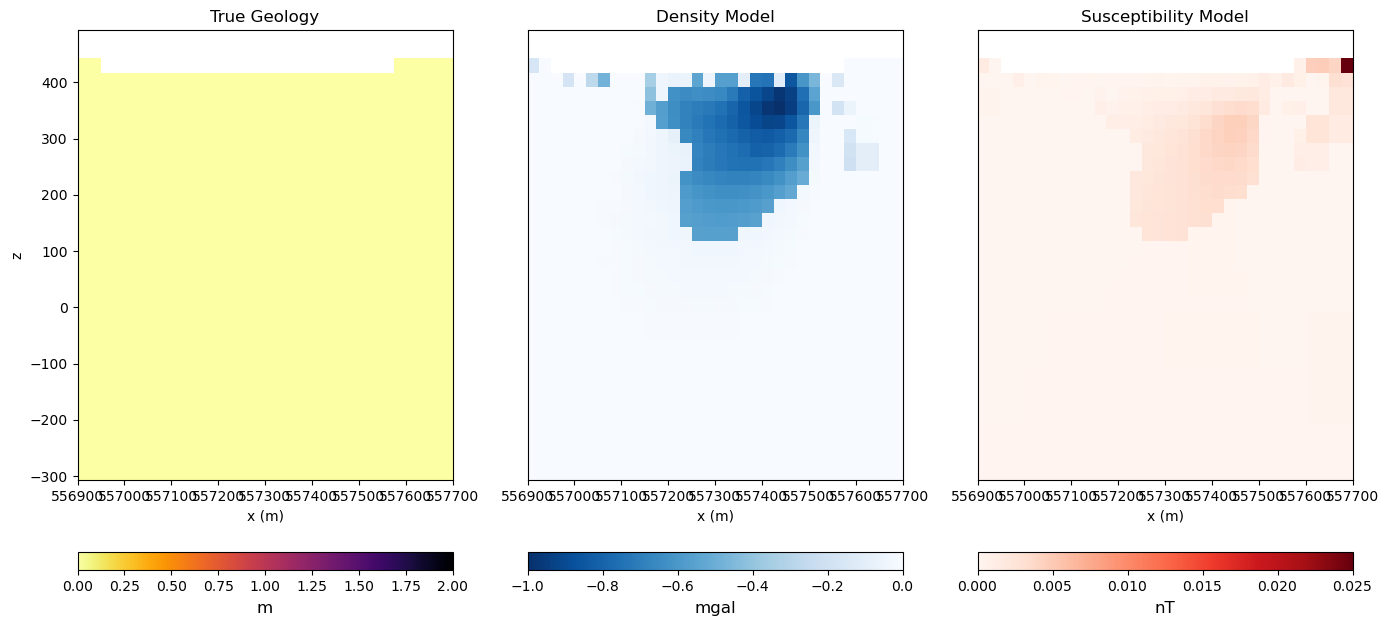

In [86]:
plot_models(quasi_geo_model_2, density_model_2, susceptibility_model_2)

C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\devin\anaconda3\envs\simpeg-user-tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


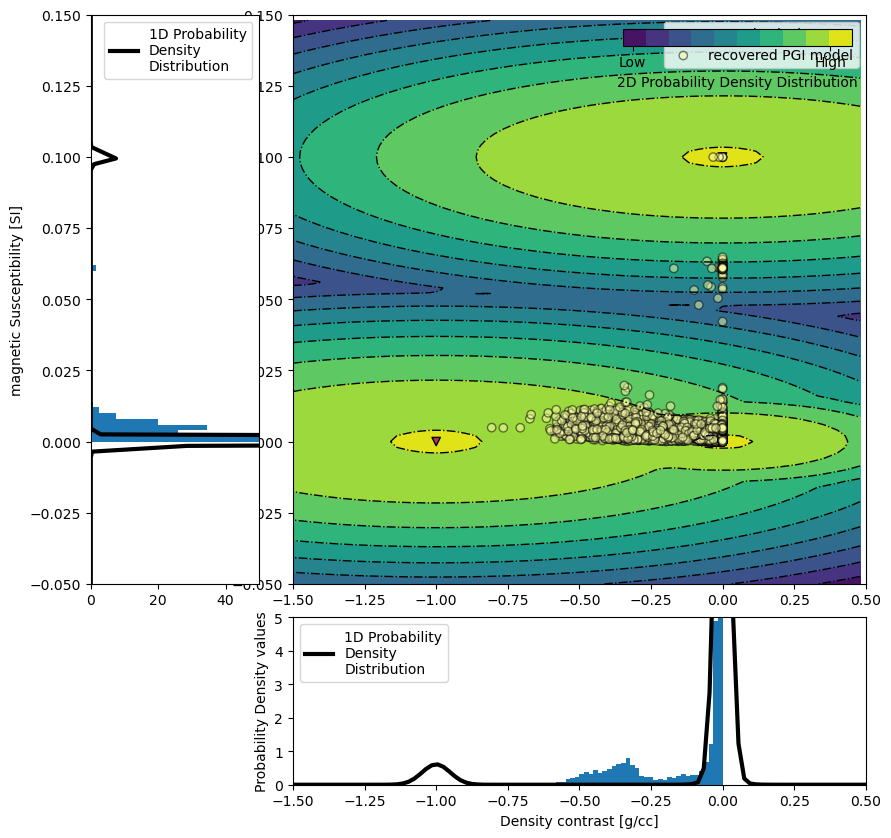

In [90]:
# Plot the 2D GMM
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((4, 4), (3, 1), colspan=3)
ax1 = plt.subplot2grid((4, 4), (0, 1), colspan=3, rowspan=3)
ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=3)
ax = [ax0, ax1, ax2]
reg_2.objfcts[0].gmm.plot_pdf(flag2d=True, ax=ax, padding=0.5)
ax[0].set_xlabel("Density contrast [g/cc]")
ax[0].set_ylim([0, 5])
ax[2].set_xlim([0, 50])
ax[2].set_ylabel("magnetic Susceptibility [SI]")
ax[1].scatter(
    density_model_2[active_cells],
    susceptibility_model_2[active_cells],
    c=quasi_geo_model_2[active_cells],
    cmap="inferno_r",
    edgecolors="k",
    label="recovered PGI model",
    alpha=0.5,
)
ax[1].legend()
ax[0].hist(density_model_2[active_cells], density=True, bins=50)
ax[2].hist(susceptibility_model_2[active_cells], density=True, bins=50, orientation="horizontal")
plt.show()